In [11]:
# 1. THE STABILITY FIX
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"          # disable GPU completely
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"

import tensorflow as tf
tf.config.optimizer.set_jit(False)
tf.config.set_visible_devices([], "GPU")          # extra safety if TF still sees GPU

--- Starting Part 1: Data Analysis ---

[1] Analyzing Pharma Giants...


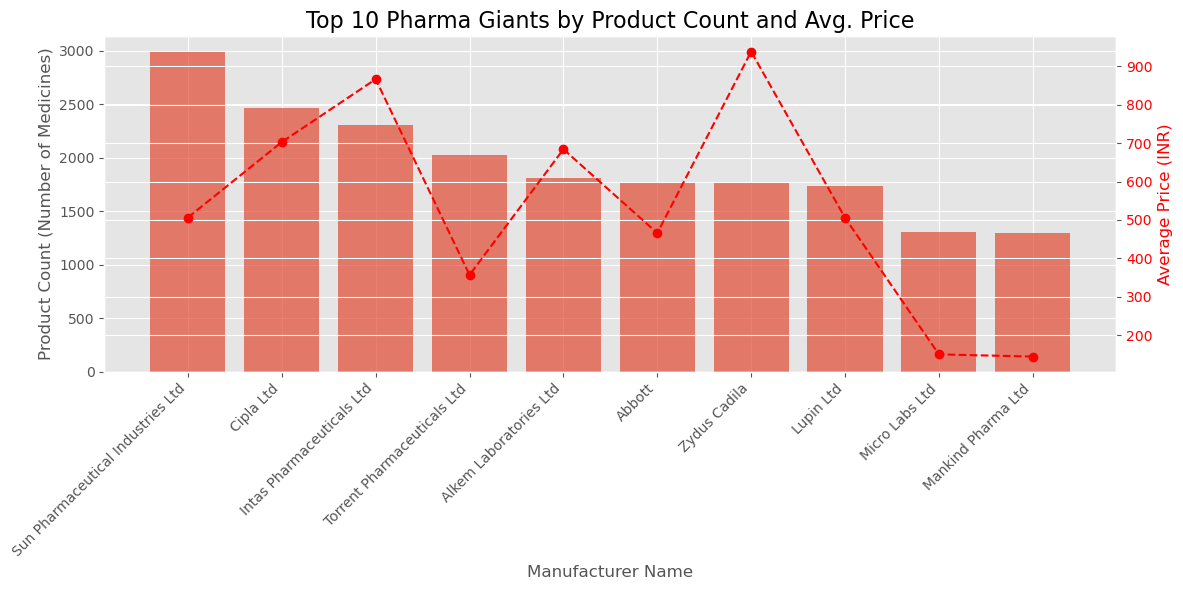


[2] Checking Product Lifecycle Status (Discontinued Products)...
Total Products: 253973
Discontinued Products: 7905
Percentage of Discontinued Products: 3.11%

[3] Analyzing Medicine Types...


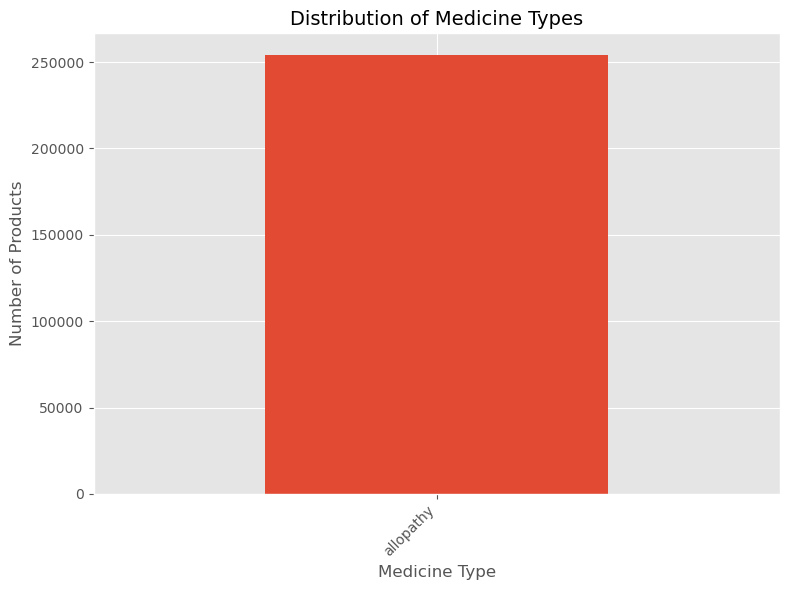

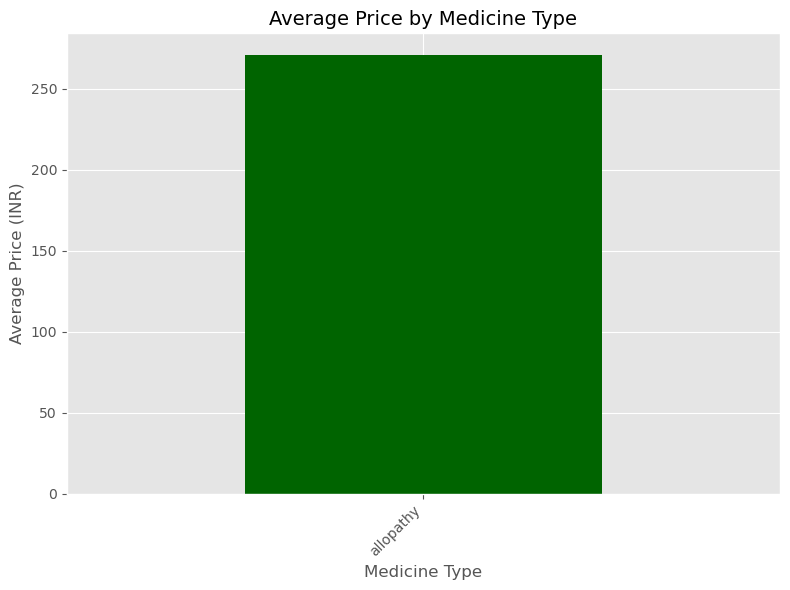


--- Medicine Type Analysis Summary ---
            Count  Average Price (INR)
type                                  
allopathy  253973           270.530844


In [12]:



import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---- Safe style setup (no seaborn-v0_8-darkgrid dependency) ----
try:
    plt.style.use("ggplot")  # always available in matplotlib
except Exception:
    try:
        import seaborn as sns
        sns.set_theme(style="darkgrid")
    except Exception:
        pass  # fallback: default matplotlib style

# Load the dataset
df = pd.read_csv("data/updated_indian_medicine_data.csv")

print("--- Starting Part 1: Data Analysis ---")

# --- 1. Pharma Giants: Product Count & Average Price ---
print("\n[1] Analyzing Pharma Giants...")

# Calculate product count for each manufacturer
manufacturer_counts = df["manufacturer_name"].value_counts()
top_10_manufacturers = manufacturer_counts.head(10).index

# Filter the DataFrame for only the top 10
df_top_10 = df[df["manufacturer_name"].isin(top_10_manufacturers)]

# Calculate average price for the top 10
avg_price_top_10 = (
    df_top_10.groupby("manufacturer_name")["price"].mean().reindex(top_10_manufacturers)
)

# Create a combined figure for Product Count and Average Price
fig, ax1 = plt.subplots(figsize=(12, 6))

# Use numeric x positions to avoid tick/label mismatch
x = np.arange(len(top_10_manufacturers))

# Plot Product Count (Primary Axis)
ax1.bar(x, manufacturer_counts.head(10).values, alpha=0.7)
ax1.set_xlabel("Manufacturer Name")
ax1.set_ylabel("Product Count (Number of Medicines)")
ax1.set_title("Top 10 Pharma Giants by Product Count and Avg. Price", fontsize=16)

ax1.set_xticks(x)
ax1.set_xticklabels(top_10_manufacturers, rotation=45, ha="right")

# Plot Average Price (Secondary Axis)
ax2 = ax1.twinx()
ax2.plot(x, avg_price_top_10.values, color="red", marker="o", linestyle="--")
ax2.set_ylabel("Average Price (INR)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Save the combined figure
plt.tight_layout()
plt.savefig("images/manufacturer_analysis.png", dpi=200)
plt.show()
plt.close()

# --- 2. Product Lifecycle Status: Discontinued Percentage ---
print("\n[2] Checking Product Lifecycle Status (Discontinued Products)...")

# If Is_discontinued is boolean, sum() works; if it's 0/1 ints, also works.
discontinued_count = df["Is_discontinued"].sum()
total_products = len(df)
discontinued_percentage = (discontinued_count / total_products) * 100

print(f"Total Products: {total_products}")
print(f"Discontinued Products: {discontinued_count}")
print(f"Percentage of Discontinued Products: {discontinued_percentage:.2f}%")

# --- 3. Medicine Types: Distribution and Average Price ---
print("\n[3] Analyzing Medicine Types...")

# Calculate distribution of medicine types
type_distribution = df["type"].value_counts()

# Calculate average price per medicine type
avg_price_by_type = df.groupby("type")["price"].mean().sort_values(ascending=False)

# Plot Type Distribution
plt.figure(figsize=(8, 6))
type_distribution.plot(kind="bar")
plt.title("Distribution of Medicine Types", fontsize=14)
plt.xlabel("Medicine Type")
plt.ylabel("Number of Products")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("images/type_distribution.png", dpi=200)
plt.show()
plt.close()

# Plot Average Price by Type
plt.figure(figsize=(8, 6))
avg_price_by_type.plot(kind="bar", color="darkgreen")
plt.title("Average Price by Medicine Type", fontsize=14)
plt.xlabel("Medicine Type")
plt.ylabel("Average Price (INR)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("images/avg_price_by_type.png", dpi=200)
plt.show()
plt.close()

# Display key data points as a table for the user
type_analysis_df = pd.DataFrame(
    {
        "Count": type_distribution,
        "Average Price (INR)": avg_price_by_type.reindex(type_distribution.index),
    }
)

print("\n--- Medicine Type Analysis Summary ---")
print(type_analysis_df)


In [13]:
import pandas as pd
import re

# Load the dataset
df = pd.read_csv("data/updated_indian_medicine_data.csv")
df_fe = df.copy()

print("--- Starting Part 2: Feature Engineering (Alchemy of Dosage) ---")

# --- Step 1: Extract Active Ingredient Name (Salt_Name) ---
# Vibe: "Reading what's *really* in the pill."
# Applying .str accessor directly to the Series.
df_fe['Salt_Name'] = df_fe['short_composition1'].str.split(' \(').str[0].str.strip()

print(f"\n[1] Extracted 'Salt_Name'. Showing top 5 unique salts:")
print(df_fe['Salt_Name'].value_counts().head(50))

# --- Step 2: Extract Dosage Value and Unit ---
# Using a single regex extraction that returns all groups.
# Regex pattern: (\d*\.?\d+)\s*([a-zA-Z]+)

regex_dosage = r'\((\d*\.?\d+)\s*([a-zA-Z]+)\)'

# Extract both groups at once
extracted_data = df_fe['short_composition1'].str.extract(regex_dosage, flags=re.IGNORECASE)

# Assign Dosage Value (Group 1)
df_fe['Dosage_Value'] = pd.to_numeric(extracted_data[0], errors='coerce')

# Assign Dosage Unit (Group 2), converted to lower case
df_fe['Dosage_Unit'] = extracted_data[1].str.lower()

# --- Step 3: Handle Multi-Component Drugs (short_composition2) ---
df_fe['Is_Multi_Salt'] = df_fe['short_composition2'].notna()

print(f"\n[2] Extracted 'Dosage_Value' and 'Dosage_Unit'.")
print(f"Products with Dosage Value: {df_fe['Dosage_Value'].notna().sum()}/{len(df_fe)}")

# --- Step 4: Final Check and Output ---
df_output = df_fe[['name', 'short_composition1', 'Salt_Name', 'Dosage_Value', 'Dosage_Unit', 'Is_Multi_Salt']].head(15)

print("\n--- Feature Engineering Results (First 15 Rows) ---")
print(df_output.to_markdown(index=False))

# Save the new DataFrame for the next ML step
df_fe.to_csv("features_engineered_medicine_data.csv", index=False)
print("\nNew data with engineered features saved to 'features_engineered_medicine_data.csv'.")


# todo fix dosage extraction for rows such as  Ambroxol (30mg/5ml) - show how human analysis of the output is important

--- Starting Part 2: Feature Engineering (Alchemy of Dosage) ---

[1] Extracted 'Salt_Name'. Showing top 5 unique salts:
Salt_Name
Cefixime                    8992
Domperidone                 8869
Aceclofenac                 8683
Amoxycillin                 8550
Ofloxacin                   6768
Ceftriaxone                 6185
Cefpodoxime Proxetil        6098
Levocetirizine              5973
Glimepiride                 5265
Azithromycin                4859
Diclofenac                  4857
Telmisartan                 4099
Nimesulide                  3304
Cefuroxime                  3267
Methylcobalamin             3183
Pantoprazole                2825
Itraconazole                2639
Rabeprazole                 2513
Ondansetron                 2500
Ambroxol                    2384
Paracetamol                 2332
Levofloxacin                2324
Atorvastatin                2318
Metformin                   2247
Deflazacort                 2126
Chlorpheniramine Maleate    2063
Etoricoxib 

--- Starting Part 3: Machine Learning (Price Prediction) ---

[1] Data Prepared. Total Features (Columns): 102


/var/folders/w1/_ftnzz4s0jdb0cyn80m370dr0000gn/T/ipykernel_89159/2940320919.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Salt_Name_Grouped'] = np.where(X['Salt_Name'].isin(top_salts), X['Salt_Name'], 'Other_Salt')
/var/folders/w1/_ftnzz4s0jdb0cyn80m370dr0000gn/T/ipykernel_89159/2940320919.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Manufacturer_Grouped'] = np.where(X['manufacturer_name'].isin(top_manufacturers), X['manufacturer_name'], 'Other_Manufacturer')



[2] Model Evaluation (Random Forest Regressor):
R-squared (R²): 0.3303 (How much variance is explained by the model)
Mean Absolute Error (MAE): 79.54 INR (Average error in price prediction)
Root Mean Square Error (RMSE): 199.37 INR


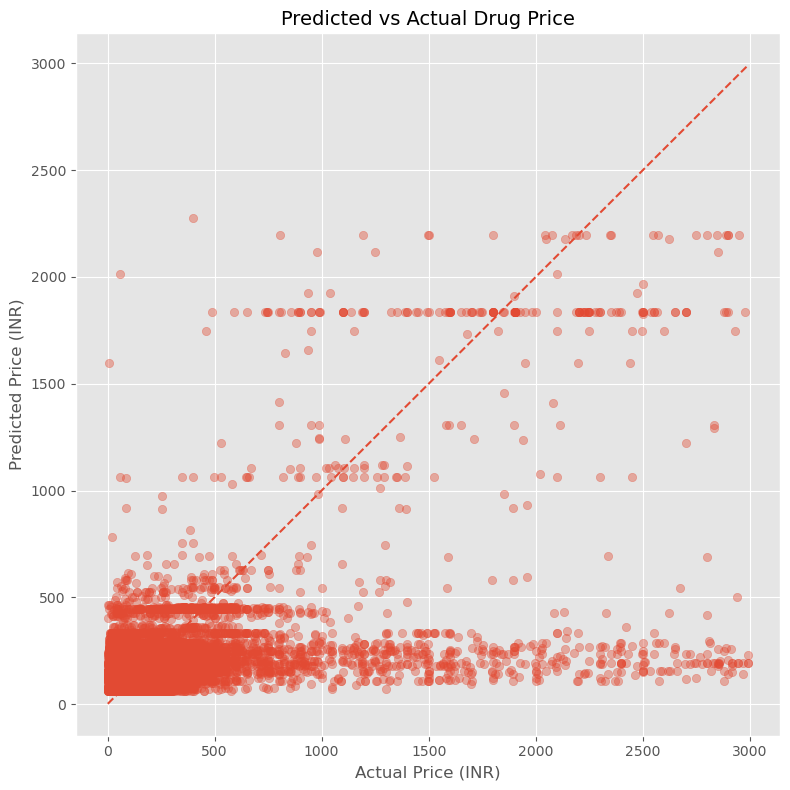


Predicted vs actual plot saved to 'predicted_vs_actual.png'.


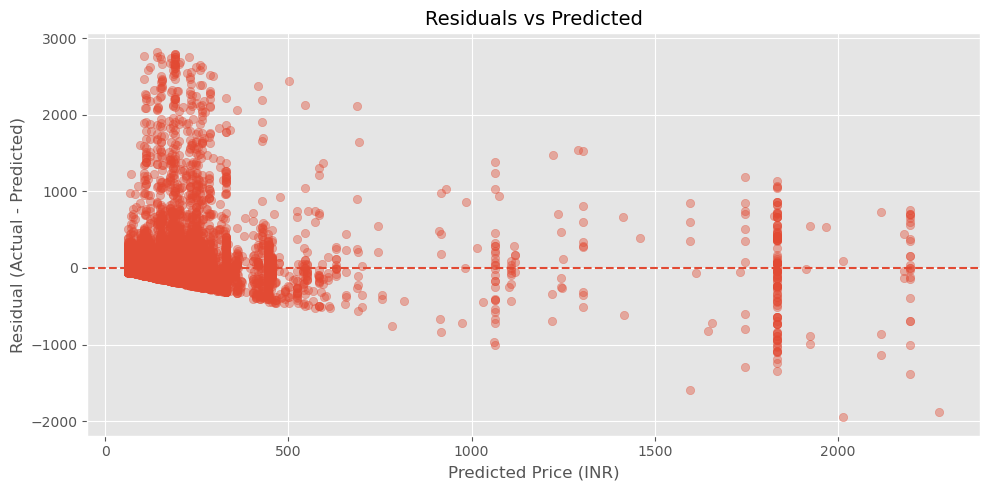

Residuals plot saved to 'residuals_vs_predicted.png'.

[3] Feature Importance (Top 10 Drivers of Price):
|                                         |          0 |
|:----------------------------------------|-----------:|
| Salt_Name_Grouped_Meropenem             | 0.439013   |
| Dosage_Value                            | 0.301154   |
| Salt_Name_Grouped_Other_Salt            | 0.073186   |
| Salt_Name_Grouped_Cefuroxime            | 0.0414733  |
| Is_Multi_Salt                           | 0.0302667  |
| Salt_Name_Grouped_Methylprednisolone    | 0.0185182  |
| Manufacturer_Grouped_Other_Manufacturer | 0.0102296  |
| Salt_Name_Grouped_Progesterone          | 0.00879702 |
| Salt_Name_Grouped_Cefpodoxime Proxetil  | 0.007811   |
| Manufacturer_Grouped_Hetero Drugs Ltd   | 0.00609279 |


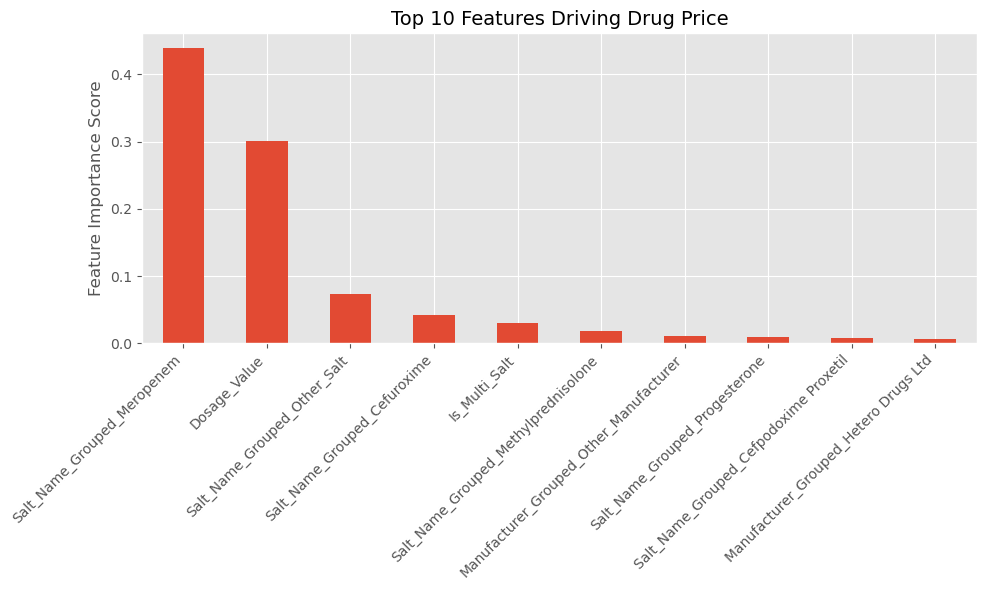


Feature importance visualization saved to 'price_feature_importance.png'.


In [14]:
# TODO show the fisrt version of regression created by AI and then the improved version

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt


# --- 1. Load Data ---
# Load the data with engineered features from Part 2
try:
    df = pd.read_csv("features_engineered_medicine_data.csv")
except FileNotFoundError:
    print("Error: 'features_engineered_medicine_data.csv' not found. Please ensure Part 2 was executed successfully.")
    exit()

print("--- Starting Part 3: Machine Learning (Price Prediction) ---")

# --- 2. Data Cleaning and Preparation ---

# Drop rows where critical features (Dosage or Salt) are missing
df.dropna(subset=['Dosage_Value', 'Salt_Name'], inplace=True)

# Remove outliers in price (e.g., top 1%) for a more robust model of typical prices
price_threshold = df['price'].quantile(0.99)
df = df[df['price'] < price_threshold]

# --- 3. Feature Selection and Categorical Handling (Top N Encoding) ---
N_CATEGORIES = 50

# Target Variable
Y = df['price']

# Features
X = df[['Dosage_Value', 'Is_Multi_Salt', 'Salt_Name', 'manufacturer_name']]

# Handle 'Salt_Name' (Vibe: "Does the ingredient type drive the price?")
top_salts = X['Salt_Name'].value_counts().head(N_CATEGORIES).index
X['Salt_Name_Grouped'] = np.where(X['Salt_Name'].isin(top_salts), X['Salt_Name'], 'Other_Salt')

# Handle 'manufacturer_name' (Vibe: "Does the brand name drive the price?")
top_manufacturers = X['manufacturer_name'].value_counts().head(N_CATEGORIES).index
X['Manufacturer_Grouped'] = np.where(X['manufacturer_name'].isin(top_manufacturers), X['manufacturer_name'], 'Other_Manufacturer')

# Drop original high-cardinality columns
X = X.drop(columns=['Salt_Name', 'manufacturer_name'])

# Apply One-Hot Encoding to the grouped categorical columns
X_encoded = pd.get_dummies(X, columns=['Salt_Name_Grouped', 'Manufacturer_Grouped'], drop_first=True)

print(f"\n[1] Data Prepared. Total Features (Columns): {X_encoded.shape[1]}")

# --- 4. Model Training ---

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=42)

# Train a powerful yet interpretable model: Random Forest Regressor
# Vibe: "The Price Crystal Ball"
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, Y_train)

# --- 5. Model Evaluation ---

Y_pred = model.predict(X_test)

r2 = r2_score(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
rmse = np.sqrt(np.mean((Y_test - Y_pred)**2))


print(f"\n[2] Model Evaluation (Random Forest Regressor):")
print(f"R-squared (R²): {r2:.4f} (How much variance is explained by the model)")
print(f"Mean Absolute Error (MAE): {mae:.2f} INR (Average error in price prediction)")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} INR")


# --- 5b. Predicted vs Actual Plot ---
plt.figure(figsize=(8, 8))
plt.scatter(Y_test, Y_pred, alpha=0.4)
plt.title('Predicted vs Actual Drug Price', fontsize=14)
plt.xlabel('Actual Price (INR)', fontsize=12)
plt.ylabel('Predicted Price (INR)', fontsize=12)

# y = x reference line
min_v = min(Y_test.min(), Y_pred.min())
max_v = max(Y_test.max(), Y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle='--')

plt.tight_layout()
plt.savefig('images/predicted_vs_actual.png', dpi=200)
plt.show()
plt.close()
print("\nPredicted vs actual plot saved to 'predicted_vs_actual.png'.")


residuals = Y_test - Y_pred
plt.figure(figsize=(10, 5))
plt.scatter(Y_pred, residuals, alpha=0.4)
plt.axhline(0, linestyle='--')
plt.title('Residuals vs Predicted', fontsize=14)
plt.xlabel('Predicted Price (INR)', fontsize=12)
plt.ylabel('Residual (Actual - Predicted)', fontsize=12)
plt.tight_layout()
plt.savefig('images/residuals_vs_predicted.png', dpi=200)
plt.show()
plt.close()
print("Residuals plot saved to 'residuals_vs_predicted.png'.")


# --- 6. Model Interpretation (Feature Importance) ---
# Vibe: "Peeking into the AI's Mind: What truly drives the cost?"

feature_importances = pd.Series(model.feature_importances_, index=X_encoded.columns)
top_10_importances = feature_importances.sort_values(ascending=False).head(10)

print("\n[3] Feature Importance (Top 10 Drivers of Price):")
print(top_10_importances.to_markdown())

# Save importance plot
plt.figure(figsize=(10, 6))
top_10_importances.plot(kind='bar')
plt.title('Top 10 Features Driving Drug Price', fontsize=14)
plt.ylabel('Feature Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('images/price_feature_importance.png', dpi=200)
plt.show()
plt.close()
print("\nFeature importance visualization saved to 'price_feature_importance.png'.")


--- Starting Part 3: Machine Learning (Price Prediction) ---

[1] Data Prepared. Total Features (Columns): 291
Rows used for training: 217772

[2] Model Evaluation (HistGradientBoostingRegressor + log1p target):
R-squared (R²): 0.2682
Mean Absolute Error (MAE): 60.59 INR
Root Mean Square Error (RMSE): 188.58 INR


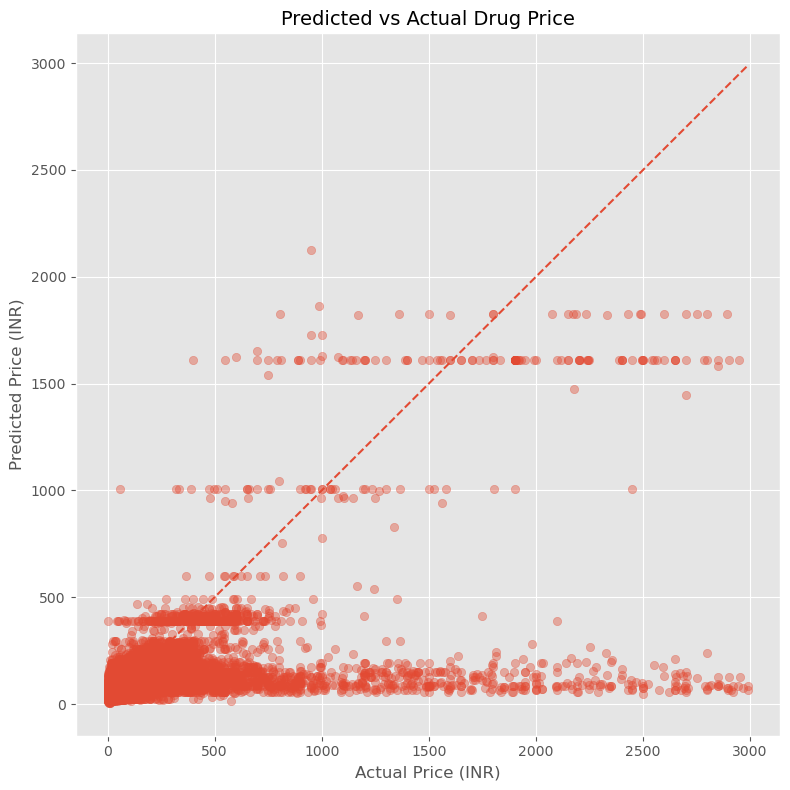


Predicted vs actual plot saved to 'predicted_vs_actual.png'.


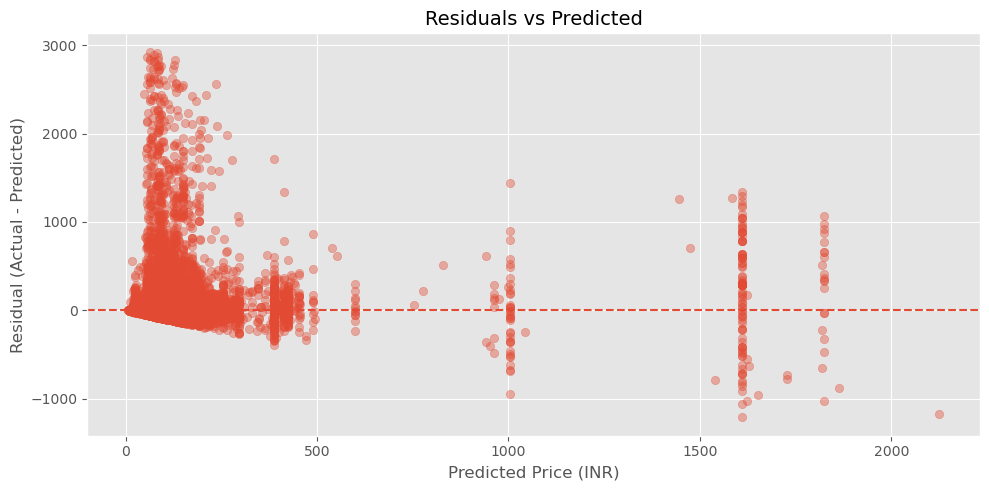

Residuals plot saved to 'residuals_vs_predicted.png'.

[3] Permutation Importance (Top 10 Drivers of Price):


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Dosage_mg                                 0.286406
Is_Multi_Salt                             0.139739
Salt_Name_Grouped_Other_Salt              0.054989
Salt_Name_Grouped_Meropenem               0.050750
Salt_Name_Grouped_Cefuroxime              0.036222
Salt_Name_Grouped_Diclofenac              0.029093
Salt_Name_Grouped_Nimesulide              0.025779
Salt_Name_Grouped_Paracetamol             0.020805
Salt_Name_Grouped_Itraconazole            0.014978
Salt_Name_Grouped_Cefpodoxime Proxetil    0.014535


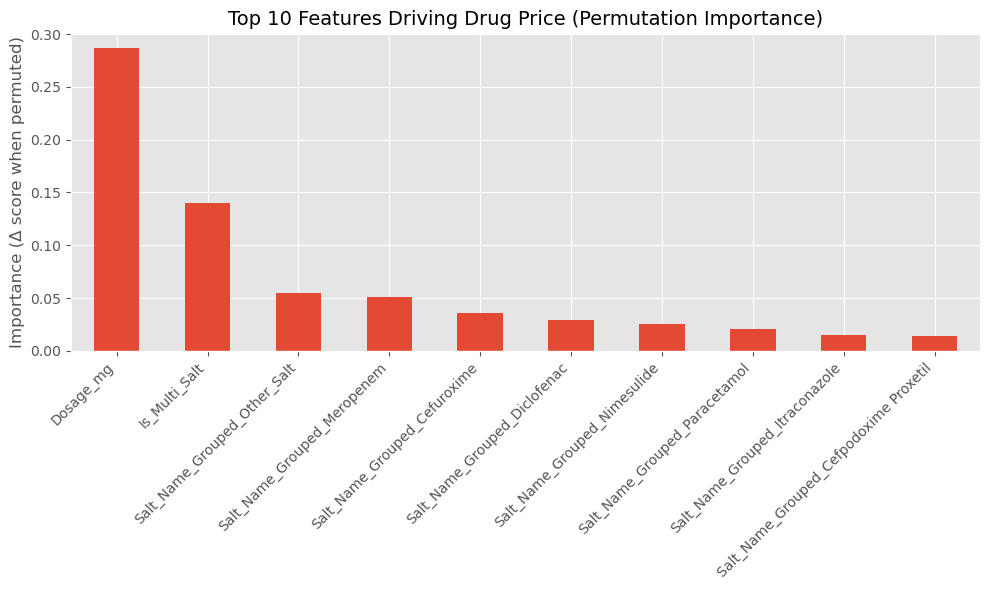


Feature importance visualization saved to 'price_feature_importance.png'.


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt


# --- 1. Load Data ---
try:
    df = pd.read_csv("features_engineered_medicine_data.csv")
except FileNotFoundError:
    print("Error: 'features_engineered_medicine_data.csv' not found. Please ensure Part 2 was executed successfully.")
    exit()

print("--- Starting Part 3: Machine Learning (Price Prediction) ---")

# --- 2. Data Cleaning and Preparation ---

# Drop rows where critical features are missing
df.dropna(subset=['Dosage_Value', 'Dosage_Unit', 'Salt_Name', 'manufacturer_name', 'price'], inplace=True)

# Remove extreme outliers in price (top 1%)
price_threshold = df['price'].quantile(0.99)
df = df[df['price'] < price_threshold]

# Normalize dosage units into mg-equivalent
DOSAGE_MULTIPLIER = {
    'mg': 1.0,
    'g': 1000.0,
    'mcg': 0.001,
    'ug': 0.001,   # sometimes micrograms appear as ug
    'iu': np.nan,  # unknown conversion; will be dropped
}

df['Dosage_Unit'] = df['Dosage_Unit'].astype(str).str.lower().str.strip()
df['Dosage_mg'] = df['Dosage_Value'] * df['Dosage_Unit'].map(DOSAGE_MULTIPLIER)

# Drop rows where we couldn't convert dosage to mg
df.dropna(subset=['Dosage_mg'], inplace=True)

# --- 3. Feature Selection and Categorical Handling (Top N Encoding) ---
N_CATEGORIES = 50

# Target: log1p(price) for better modeling
Y = np.log1p(df['price'])

# Features
X = df[['Dosage_mg', 'Is_Multi_Salt', 'Salt_Name', 'manufacturer_name']].copy()

# Group top salts
top_salts = X['Salt_Name'].value_counts().head(N_CATEGORIES).index
X['Salt_Name_Grouped'] = np.where(X['Salt_Name'].isin(top_salts), X['Salt_Name'], 'Other_Salt')

# Group top manufacturers
top_manufacturers = X['manufacturer_name'].value_counts().head(N_CATEGORIES).index
X['Manufacturer_Grouped'] = np.where(
    X['manufacturer_name'].isin(top_manufacturers),
    X['manufacturer_name'],
    'Other_Manufacturer'
)

# Optional: salt seen at strength buckets (interaction-ish)
X['Dosage_Bin'] = pd.qcut(X['Dosage_mg'], q=5, duplicates='drop').astype(str)
X['Salt_x_DosageBin'] = X['Salt_Name_Grouped'].astype(str) + "_" + X['Dosage_Bin'].astype(str)

# Drop originals (high cardinality)
X = X.drop(columns=['Salt_Name', 'manufacturer_name', 'Dosage_Bin'])

# One-hot encode categoricals
X_encoded = pd.get_dummies(
    X,
    columns=['Salt_Name_Grouped', 'Manufacturer_Grouped', 'Salt_x_DosageBin'],
    drop_first=True
)

print(f"\n[1] Data Prepared. Total Features (Columns): {X_encoded.shape[1]}")
print(f"Rows used for training: {len(X_encoded)}")

# --- 4. Model Training ---
X_train, X_test, Y_train, Y_test = train_test_split(
    X_encoded, Y, test_size=0.2, random_state=42
)

# Gradient boosting generally beats RF on tabular problems like this
model = HistGradientBoostingRegressor(
    max_depth=8,
    learning_rate=0.05,
    max_iter=400,
    random_state=42
)
model.fit(X_train, Y_train)

# --- 5. Model Evaluation (report in INR scale) ---
Y_pred_log = model.predict(X_test)

# Convert back to INR
Y_test_inr = np.expm1(Y_test)
Y_pred_inr = np.expm1(Y_pred_log)

r2 = r2_score(Y_test_inr, Y_pred_inr)
mae = mean_absolute_error(Y_test_inr, Y_pred_inr)
rmse = np.sqrt(np.mean((Y_test_inr - Y_pred_inr) ** 2))

print(f"\n[2] Model Evaluation (HistGradientBoostingRegressor + log1p target):")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f} INR")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} INR")

# --- 5b. Predicted vs Actual Plot ---
plt.figure(figsize=(8, 8))
plt.scatter(Y_test_inr, Y_pred_inr, alpha=0.4)
plt.title('Predicted vs Actual Drug Price', fontsize=14)
plt.xlabel('Actual Price (INR)', fontsize=12)
plt.ylabel('Predicted Price (INR)', fontsize=12)

min_v = float(min(Y_test_inr.min(), Y_pred_inr.min()))
max_v = float(max(Y_test_inr.max(), Y_pred_inr.max()))
plt.plot([min_v, max_v], [min_v, max_v], linestyle='--')

plt.tight_layout()
plt.savefig('images/predicted_vs_actual.png', dpi=200)
plt.show()
plt.close()
print("\nPredicted vs actual plot saved to 'predicted_vs_actual.png'.")

# Residuals plot
residuals = Y_test_inr - Y_pred_inr
plt.figure(figsize=(10, 5))
plt.scatter(Y_pred_inr, residuals, alpha=0.4)
plt.axhline(0, linestyle='--')
plt.title('Residuals vs Predicted', fontsize=14)
plt.xlabel('Predicted Price (INR)', fontsize=12)
plt.ylabel('Residual (Actual - Predicted)', fontsize=12)
plt.tight_layout()
plt.savefig('images/residuals_vs_predicted.png', dpi=200)
plt.show()
plt.close()
print("Residuals plot saved to 'residuals_vs_predicted.png'.")

# --- 6. Model Interpretation (Permutation Importance) ---
# (HGBR doesn't have feature_importances_, so we use permutation importance.)
print("\n[3] Permutation Importance (Top 10 Drivers of Price):")
perm = permutation_importance(
    model,
    X_test,
    Y_test,              # IMPORTANT: use log-space here because the model was trained on it
    n_repeats=8,
    random_state=42,
    n_jobs=-1
)

importances = pd.Series(perm.importances_mean, index=X_encoded.columns).sort_values(ascending=False)
top_10 = importances.head(10)
print(top_10.to_string())

plt.figure(figsize=(10, 6))
top_10.plot(kind='bar')
plt.title('Top 10 Features Driving Drug Price (Permutation Importance)', fontsize=14)
plt.ylabel('Importance (Δ score when permuted)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('images/price_feature_importance.png', dpi=200)
plt.show()
plt.close()
print("\nFeature importance visualization saved to 'price_feature_importance.png'.")


--- Starting Part 4: Deep Learning (Digital Guardian Angel) ---

[Vibe Check] Training the model.
Epoch 1/5


/opt/miniconda3/envs/drug_analysis/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8180 - loss: 0.3705 - val_accuracy: 0.9199 - val_loss: 0.2307
Epoch 2/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9616 - loss: 0.1089 - val_accuracy: 0.9516 - val_loss: 0.1391
Epoch 3/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9785 - loss: 0.0662 - val_accuracy: 0.9683 - val_loss: 0.1049
Epoch 4/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9826 - loss: 0.0618 - val_accuracy: 0.9766 - val_loss: 0.1037
Epoch 5/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9857 - loss: 0.0482 - val_accuracy: 0.9616 - val_loss: 0.1284
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

--- Final Truth Test (Classification Report) ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       972
           1       0.97      0.96      0.97       526

    accuracy                           0.98      1498
   macro avg       0.97      0.97      0.97      1498
weighted 

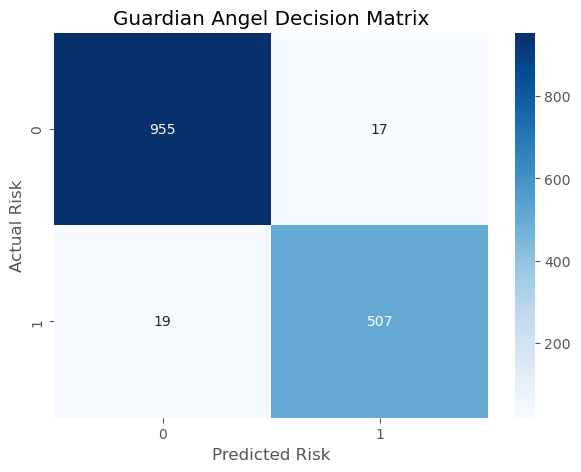

In [16]:
# ==========================================
# PART 4: DEEP LEARNING (NLP) - STABLE VERSION
# ==========================================

import pandas as pd
import numpy as np
import re
import ast
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

print("--- Starting Part 4: Deep Learning (Digital Guardian Angel) ---")

# 2. DATA LOAD & TARGETING
df = pd.read_csv("data/updated_indian_medicine_data.csv")
df_dl = df.dropna(subset=['drug_interactions', 'medicine_desc', 'side_effects']).copy()

def check_high_risk(interaction_str):
    try:
        data = ast.literal_eval(interaction_str)
        effects = data.get('effect', [])
        return 1 if any(kw in str(effects).upper() for kw in ['LIFE-THREATENING', 'SERIOUS']) else 0
    except:
        return 0

df_dl['High_Risk'] = df_dl['drug_interactions'].apply(check_high_risk)
Y = df_dl['High_Risk'].values

# 3. TEXT TO NUMBERS (The AI Lexicon)
X_text = (df_dl['medicine_desc'] + ' ' + df_dl['side_effects']).str.lower()
X_text = X_text.apply(lambda x: re.sub(r'[^a-z\s]', '', str(x)))

MAX_WORDS = 5000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<UNK>')
tokenizer.fit_on_texts(X_text)
sequences = tokenizer.texts_to_sequences(X_text)
X_padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# 4. BUILDING & TRAINING
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(MAX_WORDS, 16, input_length=MAX_LEN),
    GRU(32), # This is the "brain" that reads sequences
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("\n[Vibe Check] Training the model.")
# We use a small batch size to be gentle on the hardware
history = model.fit(X_train, Y_train, epochs=5, batch_size=16, validation_split=0.1)

# 5. EVALUATION
Y_pred = (model.predict(X_test) > 0.5).astype(int)

print("\n--- Final Truth Test (Classification Report) ---")
print(classification_report(Y_test, Y_pred))

# Confusion Matrix for the book visualization
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Guardian Angel Decision Matrix')
plt.xlabel('Predicted Risk')
plt.ylabel('Actual Risk')
plt.show()

In [17]:
# ==========================================
# PART 5: TRANSFORMERS (Modern AI)
# "The Semantic Vibe Search"
# ==========================================

# Note: You may need to install the library first:
# !pip install sentence-transformers

import pandas as pd
from sentence_transformers import SentenceTransformer, util
import torch

print("--- Starting Part 5: Transformers (Semantic Search) ---")

# 1. PREPARE DATA
# We use the subset that has descriptions (the "medical knowledge")
df = pd.read_csv("data/updated_indian_medicine_data.csv")
df_search = df.dropna(subset=['medicine_desc']).copy().reset_index(drop=True)

# To make it run fast in a notebook, we'll use the first 2000 descriptions
# df_search = df_search.head(2000)

print(f"[0] Knowledge Base ready: {len(df_search)} medicines indexed.")

# 2. LOAD THE TRANSFORMER (The Alchemist)
# Vibe: "Loading a pre-trained brain that already knows the English language."
model = SentenceTransformer('all-MiniLM-L6-v2')

# 3. VECTORIZE THE VIBE (Encoding)
# We turn medical descriptions into "Embeddings" (numerical maps of meaning)
print("[1] Encoding medical knowledge into vector space... (The AI is 'reading' the data)")
descriptions = df_search['medicine_desc'].tolist()
embeddings = model.encode(descriptions, convert_to_tensor=True)

# 4. DEFINE THE SEARCH FUNCTION
def semantic_search(query, top_k=3):
    # Vibe: "Turning the user's human words into a mathematical vector"
    query_embedding = model.encode(query, convert_to_tensor=True)
    
    # Calculate "Cosine Similarity" (how close the query vibe is to the drug vibe)
    hits = util.semantic_search(query_embedding, embeddings, top_k=top_k)
    hits = hits[0] # Get results for the first query

    print(f"\nSearch Query: '{query}'")
    print("-" * 30)
    for hit in hits:
        idx = hit['corpus_id']
        score = hit['score']
        medicine = df_search.iloc[idx]
        print(f"Medicine: {medicine['name']} (Match Score: {score:.4f})")
        # Print a snippet of why it matched
        print(f"Vibe: {medicine['medicine_desc'][:150]}...")
        print("-" * 10)

# 5. TEST THE MAGIC
# Vibe: "Testing the AI with human language instead of medical keywords."
semantic_search("I have a bad bacterial infection in my lungs")
semantic_search("Something for seasonal allergies and itchy eyes")
semantic_search("Medicine for high blood pressure")

print("\n--- Part 5 Complete. You've built a Transformer-powered Search Engine! ---")

--- Starting Part 5: Transformers (Semantic Search) ---
[0] Knowledge Base ready: 7488 medicines indexed.
[1] Encoding medical knowledge into vector space... (The AI is 'reading' the data)

Search Query: 'I have a bad bacterial infection in my lungs'
------------------------------
Medicine: Amoxycillin 500mg Capsule (Match Score: 0.4629)
Vibe: Amoxycillin 500mg Capsule is a penicillin-type of antibiotic used to treat a variety of bacterial infections. It is effective in infections of the thr...
----------
Medicine: Septran C Tablet (Match Score: 0.4599)
Vibe: Septran C Tablet is an antibiotic medicine used to treat bacterial infections in your body. It is effective in infections of the lungs (eg. pneumonia,...
----------
Medicine: Pentids 400 Tablet (Match Score: 0.4412)
Vibe: Pentids 400 Tablet is an antibiotic used to treat a variety of bacterial infections. It is effective in infections of the throat, ear, nasal sinuses, ...
----------

Search Query: 'Something for seasonal allergie

--- Glitch Report for Cefixime ---
Total Products: 8387
Anomalies Found: 163


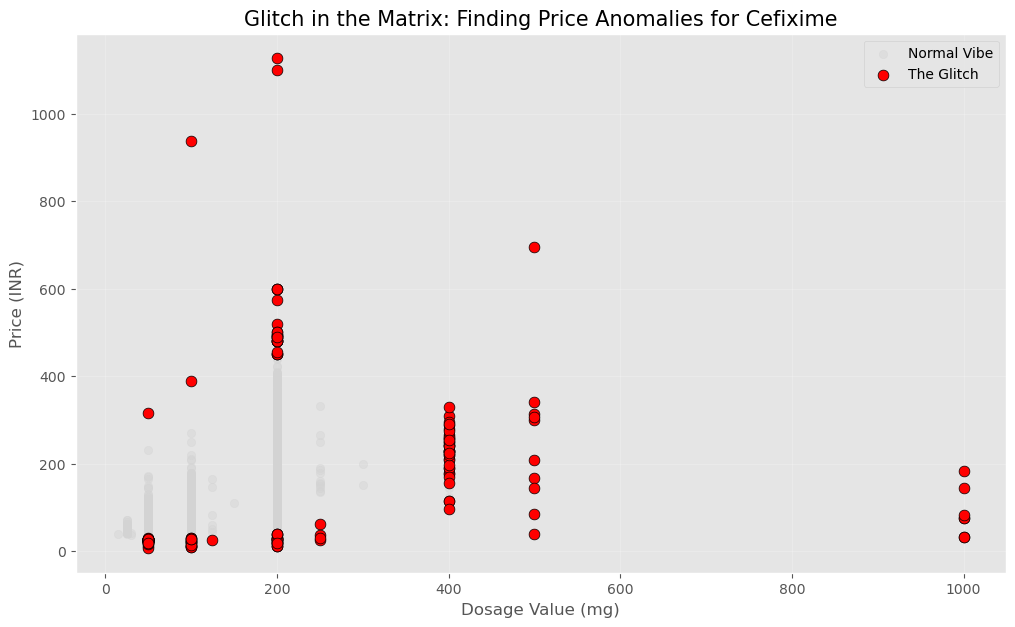


--- Top 5 Most Expensive 'Glitches' ---
                                name  Dosage_Value    price  \
246763              Zim 200mg Tablet         200.0  1126.73   
175936           Prifix 200mg Tablet         200.0  1100.00   
93731          Fiximark 100mg Tablet         100.0   937.50   
36609             CF3 O 500mg Tablet         500.0   696.00   
207070  Sumcef LZ 200mg/600mg Tablet         200.0   600.00   

                   manufacturer_name  
246763   Troikaa Pharmaceuticals Ltd  
175936            Priya Life Science  
93731   Glenmark Pharmaceuticals Ltd  
36609      Care Benzorganics Pvt Ltd  
207070              Smile Healthcare  


In [18]:
# ==========================================
# PART 6: ANOMALY DETECTION
# "The Glitch in the Matrix"
# ==========================================

import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import re

# 1. PREPARE THE VIBE (Using Cefixime as our case study)
df = pd.read_csv("data/updated_indian_medicine_data.csv")

# Extract Salt and Dosage using a robust "apply" approach
def extract_salt(comp):
    return str(comp).split(' (')[0].strip()

def extract_dosage(comp):
    match = re.search(r'\((\d*\.?\d+)\s*[a-zA-Z]+\)', str(comp))
    return float(match.group(1)) if match else np.nan

df['Salt_Name'] = df['short_composition1'].apply(extract_salt)
df['Dosage_Value'] = df['short_composition1'].apply(extract_dosage)

# Focus on Cefixime to find outliers in a single "neighborhood"
df_salt = df[(df['Salt_Name'] == 'Cefixime')].dropna(subset=['Dosage_Value', 'price']).copy()

# 2. THE ANOMALY SEARCH
# Vibe: "If most 200mg tablets cost 100-200 INR, why does this one cost 1,000?"
iso_forest = IsolationForest(contamination=0.02, random_state=42) # We expect 2% anomalies

# We use log price to keep the visualization clean
df_salt['Log_Price'] = np.log1p(df_salt['price'])

# Train the "Glitch Detector"
df_salt['Anomaly_Score'] = iso_forest.fit_predict(df_salt[['Dosage_Value', 'Log_Price']])

# -1 = Anomaly, 1 = Normal
anomalies = df_salt[df_salt['Anomaly_Score'] == -1]
normals = df_salt[df_salt['Anomaly_Score'] == 1]

print(f"--- Glitch Report for Cefixime ---")
print(f"Total Products: {len(df_salt)}")
print(f"Anomalies Found: {len(anomalies)}")

# 3. VISUALIZING THE GLITCH
plt.figure(figsize=(12, 7))
plt.scatter(normals['Dosage_Value'], normals['price'], color='lightgrey', alpha=0.4, label='Normal Vibe')
plt.scatter(anomalies['Dosage_Value'], anomalies['price'], color='red', edgecolor='black', s=60, label='The Glitch')

plt.title('Glitch in the Matrix: Finding Price Anomalies for Cefixime', fontsize=15)
plt.xlabel('Dosage Value (mg)')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

# 4. SHOW THE TOP GLITCHES
print("\n--- Top 5 Most Expensive 'Glitches' ---")
print(anomalies.sort_values(by='price', ascending=False)[['name', 'Dosage_Value', 'price', 'manufacturer_name']].head(5))

--- Starting Part 7: The Scare Scale ---
[1] Correlation between Scare Factor and Price: 0.0271


/var/folders/w1/_ftnzz4s0jdb0cyn80m370dr0000gn/T/ipykernel_89159/1444628685.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_scare = df_se.groupby('Intensity')['price'].mean()


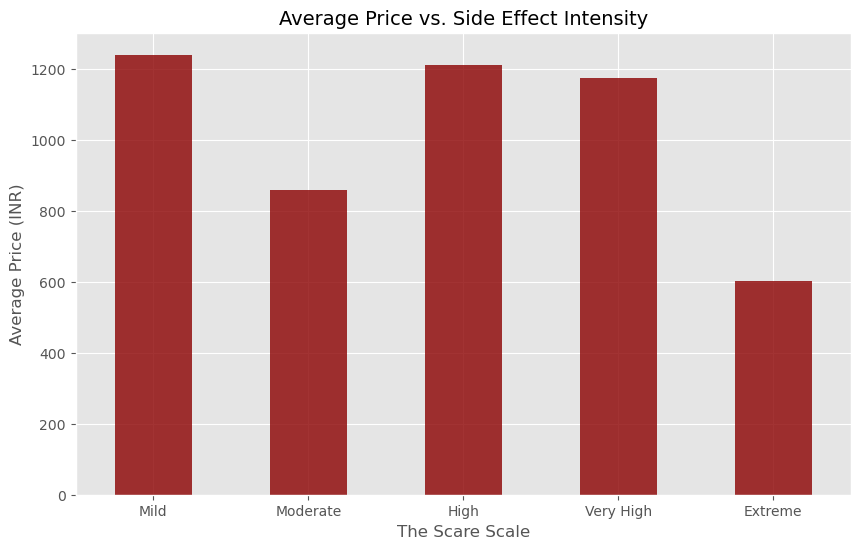


--- Spotlight: The Highest Scare Score ---
Medicine: Aneket 10mg Injection
Score: 37
Reported Effects: Rash,Erythema (skin redness),Vomiting,Nausea,Agitation,Nightmare,Abnormal behavior,Double vision,Hallucination,Increased respiratory rate ,High blood pressure,Confusion,Nystagmus (involuntary eye movement),Muscle coordination impaired,Tonic-clonic seizures,Tachycardia


In [19]:
# ==========================================
# PART 7: SENTIMENT & INTENSITY ANALYSIS
# "The Side Effect Scare Scale"
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. LOAD AND FILTER
# We only use rows that have reported side effects
df = pd.read_csv("data/updated_indian_medicine_data.csv")
df_se = df.dropna(subset=['side_effects']).copy()

print(f"--- Starting Part 7: The Scare Scale ---")

# 2. THE SEVERITY DICTIONARY (Vibe: "Quantifying the Fear")
# We assign 'weights' to specific medical terms.
severity_map = {
    'nausea': 1, 'headache': 1, 'fatigue': 1, 'sleepiness': 1, # Mild
    'vomiting': 3, 'diarrhea': 3, 'rash': 3, 'hives': 3,       # Moderate
    'blurred vision': 7, 'chest pain': 7, 'tremor': 7,         # High
    'liver damage': 15, 'kidney failure': 15, 'seizures': 15,  # Severe
    'hallucination': 15, 'anaphylaxis': 15
}

def calculate_scare_score(text):
    """Checks for keywords and sums their severity weights."""
    if pd.isna(text): return 0
    text = str(text).lower()
    score = 0
    for word, weight in severity_map.items():
        if word in text:
            score += weight
    return score

# 3. SCORING THE MEDICINES
# Vibe: "Turning a list of symptoms into a single 'Intensity' number."
df_se['Scare_Score'] = df_se['side_effects'].apply(calculate_scare_score)

# 4. ANALYSIS: DOES RISK EQUAL COST?
correlation = df_se[['Scare_Score', 'price']].corr().iloc[0, 1]
print(f"[1] Correlation between Scare Factor and Price: {correlation:.4f}")

# 5. VISUALIZING THE RESULTS
# We group scores into buckets for a cleaner "Vibe Check"
df_se['Intensity'] = pd.cut(df_se['Scare_Score'], bins=[0, 2, 5, 10, 20, 100], 
                           labels=['Mild', 'Moderate', 'High', 'Very High', 'Extreme'])

avg_price_by_scare = df_se.groupby('Intensity')['price'].mean()

plt.figure(figsize=(10, 6))
avg_price_by_scare.plot(kind='bar', color='darkred', alpha=0.8)
plt.title('Average Price vs. Side Effect Intensity', fontsize=14)
plt.ylabel('Average Price (INR)')
plt.xlabel('The Scare Scale')
plt.xticks(rotation=0)
plt.show()

# 6. THE "SCARIEST" DRUG SPOTLIGHT
scariest = df_se.loc[df_se['Scare_Score'].idxmax()]
print(f"\n--- Spotlight: The Highest Scare Score ---")
print(f"Medicine: {scariest['name']}")
print(f"Score: {scariest['Scare_Score']}")
print(f"Reported Effects: {scariest['side_effects']}")